#### Below cell contains all the self-defined function and needed libraries. For better organization and future maintainence.

In [1]:
# All the libraries and functions should be stored here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# standardise and de-standardise functions
def standardise(data_matrix):
    """
    Standardise a data matrix contains all features and output
    the standardised matrix, two array contains
    mean and standard deviation of each feature repesctively

    input:
        data_matrix(np.array): an array of shape (n_samples, n_features)

    output:
        standardised_matrix(np.array): (data_matrix - row_of_means) / row_of_stds
        row_of_means(np.array): an array contains the mean of each feature
        row_of_stds(np.array): an array contains the standard deviation of each feature
    """
    # standardised matrix
    # = (data_matrix - row_of_means) / row_of_stds
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(standardised_matrix, axis=0)
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds


def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    """
    Use the mean and standard deviation with standardized matrix to
    de-standardise back to original scale for each feature

    input:
        standardized_matrix(np.array): an np.array of shape (n_samples, n_features))
        row_of_means(np.array): an array contains the mean of each feature
        row_of_stds(np.array): an array contains the standard deviation of each feature

    output:
        original_matrix(np.array): an matrix that is de standardised from standardised array
        using row_of_means and row_of_stds
    """
    # de-standardised matrix
    # = standardised_matrix * row_of_stds + row_of_means
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means


# liner regression functions
def linear_regression_data_input(data_inputs):
    """
    By given data inputs, return a new matrix contains all 1 on first column.
    This is mainly used for weight measuring for the constant in the linear model.

    input:
        data_inputs(np.array): an array contains all features

    output:
        matrix(np.array): a new matrix contains all 1 on first column, and features on the rest
    """
    first_column = np.ones((len(data_inputs), 1))
    matrix = np.c_[first_column, data_inputs]
    return matrix


# Using our model to predict outputs
def predict_output(data_matrix, weights):
    """
    By given data matrix and weights, return data_matrix @ weights as outputs.

    input:
        data_matrix(np.array): an array contains all features
        weights(np.array): an array contains all weights for it's corresponding features

    output:
        data_matrix @ weights(np.array): an array contains all predicted outputs
    """
    return data_matrix @ weights


def classification_accuracy(estimated_labels, true_labels):
    """
    Compute the accuracy level of our model

    input:
        estimated_labels(np.array): an array contains all estimated labels
        true_labels(np.array): an array contains all true labels

    output:
        accuracy(float): the accuracy level of our model
    """
    equal_labels = estimated_labels == true_labels
    return np.mean(equal_labels)


# comparison plot between paired feature and output
def compare_plot(data_input, data_output):
    """
    Plot the comparison between pair features and our label

    input:
        data_input(np.array): an array contains all standardised features
        data_output(np.array): an array contains our labels

    output:
        Plots showing comparison between paired features and relationship with our label
    """
    feature_names = [
        "Pregnancies",
        "Glucose",
        "Blood Pressure",
        "Skin Thickness",
        "Insulin",
        "BMI",
        "Diabetes Pedigree Function",
        "Age",
    ]
    diabetes_destd_data = de_standardise(
        data_input, data_row_of_means, data_row_of_stds
    )
    daibetes_dataframe = pd.DataFrame(data=diabetes_destd_data, columns=feature_names)
    daibetes_dataframe["Outcome"] = data_output

    # start plotting using seaborn
    sns.set_theme(style="ticks", color_codes=True)
    g = sns.PairGrid(daibetes_dataframe, vars=daibetes_dataframe[:-1], hue="Outcome")
    g.map_offdiag(sns.scatterplot)
    g.map_diag(plt.hist)
    g.add_legend(title="Outcome")
    # set axis labels
    for ax in g.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), fontsize="large")
        ax.set_ylabel(ax.get_ylabel(), fontsize="large")
    # Set main title
    plt.suptitle(
        "Pairwise relationships and distributions of features by Outcome",
        size=20,
        y=1.03,
    )
    plt.show()
    plt.tight_layout


# Kfold cross validation
def KFold_split(data_size, K):
    """
    Splits indices of a dataset into K approximately equal parts for cross-validation.

    input:
        data_size(int): The total number of data points in the dataset.
        K(int): The number of folds.

    output:
        kfold_split(list of np.array): List of arrays, each array is a set of indices representing a fold.
    """
    kfold_split = []
    # Randomly shuffle indices
    all_index = np.random.choice(
        [_ for _ in range(data_size)], data_size, replace=False
    )
    quotient, remainder = divmod(data_size, K)
    start_index = 0
    for fold_index in range(K):
        if fold_index < remainder:
            end_index = start_index + quotient + 1
        else:
            end_index = start_index + quotient
        kfold_split.append(all_index[start_index:end_index])
        start_index = end_index

    return kfold_split


def KFold_cross_validation(
    data_matrix, data_outputs, K, training_algorithm, error_evaluation
):
    """
    Using KFold_split to split the data into K folds and return
    the optimal weights and validation error

    input:
        data_matrix(np.array): array of features
        data_outputs(np.array): array of labels
        K(int): number of folds
        training_algorithm(function): a function used to trained your model
        error_evaluation(function): a function used to compute the error between trained model
        and validation data

    output:
        optimal_weights(np.array): optimal weights
        validation_error(float): prediction error
    """
    data_size = len(data_matrix)
    indexes_split = KFold_split(data_size, K)

    # initialize the optimal weights and validation error
    optimal_weights = 0
    validation_error = 0
    for i in range(K):
        # the i split is used for validation
        # the rest of the splits(j!=i) are used for training
        indexes = np.concatenate([indexes_split[j] for j in range(K) if (j != i)])

        # training with j splits
        weights = training_algorithm(data_matrix[indexes], data_outputs[indexes])
        # using the trained weithts, model, to preict the label in i split
        # compute the error using the trained weights
        # to valiate the error in i split(validation data)
        error = error_evaluation(
            data_matrix[indexes_split[i]], data_outputs[indexes_split[i]], weights
        )
        # Overall performance is simply the average value among splits
        optimal_weights += weights / K
        validation_error += error / K

    return optimal_weights, validation_error


def grid_search(objective, grid):
    """
    The function is used to put every grid point into our objective function
    in this case, a cost funtion, and return the grid point that
    has the smallest value for the cost function

    meaning, our target = argmin(objective(grid))

    input:
        objective(function): the cost function that we want to minimize
        grid(np.array): array of grid points
    output:
        grid[np.argmin(values)](np.array): the grid point that has the smallest value

    """
    values = np.array([])
    for point in grid:
        values = np.append(values, objective(point))
    return grid[np.argmin(values)]


# function for computing pairwise distances
def distance(from_data, to_data):
    """
    By given data1 and data2, return a nparray contains the distance between
    paired vectors in 2 data sets.

    For example, data1 contains vector: v1, v2,3 and data2 contains vector: v4, v5, v6
    the output will give you an array contains distance between
    [dist(v1, v4), dist(v1, v5), dist(v1, v6), dist(v2, v4), dist(v2, v5)......dist(v3, v6)]

    input:
        from_data(np.array): an array contains all features
        to_data(np.array): an array contains all features

    output:
        distance(np.array): an array contains all distance between paired vectors in two data sets
    """
    distance = np.zeros((len(from_data), len(to_data)), float)
    counter_1 = 0
    for vector_x in from_data:
        first_vector = vector_x
        counter_2 = 0
        for vector_y in to_data:
            second_vector = vector_y
            distance[counter_1, counter_2] = np.sqrt(np.sum((vector_x - vector_y) ** 2))
            counter_2 += 1
        counter_1 += 1
    return distance


# nearest neighbor classification
def binary_nearest_neighbor_classification(
    inputs_to_be_predicted, train_inputs, train_outpus, no_of_neighbor
):
    """
    By given inputs_to_be_predicted, train_inputs, train_outpus, no_of_neighbor
    return the predicted labels for inputs_to_be_predicted

    input:
        inputs_to_be_predicted(np.array): an array contains all test features to be predicted
        (Use for validation)
        train_inputs(np.array): an array contains all train features
        train_outpus(np.array): an array contains all train labels
        no_of_neighbor(int): number of neighbors to consider

    output:
        predicted_labels(np.array): an array contains all predicted labels for inputs_to_be_predicted
    """
    # first thing is to compute pairwise distances

    distances = distance(inputs_to_be_predicted, train_inputs)

    # since in a binary classification problem, we only have 2 classes
    no_of_classes = 2
    # sort the distances, return the index
    sorted_index = np.argsort(distances, axis=1)

    no_of_test = len(inputs_to_be_predicted)
    no_of_train_data = len(train_inputs)
    # broadcast the train_outpus to the shape of (no_of_test, no_of_train_data)
    train_outpus = train_outpus.reshape(-1)
    new_array_to_sort = np.broadcast_to(train_outpus, (no_of_test, no_of_train_data))
    # sort the labels
    sorted_labels = np.take_along_axis(new_array_to_sort, sorted_index, 1)

    # initialize the predicted labels as 0 for every test data
    predicted_labels = np.zeros(no_of_test, int)
    for test in range(no_of_test):
        # initialize the vote as 0 for every test data
        vote = np.zeros(no_of_classes, float)
        # loop through all neighbors, and neighbors give vote to predict label for test data
        for neighbor in range(0, no_of_neighbor):
            neighbor_label = int(sorted_labels[test][neighbor])
            vote[neighbor_label] += 1.0 / no_of_neighbor

        # for each test, the label with the highest vote is the predicted label
        predicted_labels[test] = np.argmax(vote)

    return predicted_labels

#### Math used in this project
1. Logistic Function
    1. It takes a number input and map into a value between 0~1
    1. Then outputs of the logistic function can be interpreted as probabilities.
    1. We define output as 1 when p(x) > 0.5 and 0 otherwise 
$$
\sigma(x) := \frac{1}{1 + e^{-x}}
$$

2. Link with logit function
$$
\rho(1 | x) = \sigma(\langle x, w \rangle) = \frac{1}{1 + e^{-\langle x, w \rangle}}
$$


In [2]:
def logistic_function(inputs):
    """
    By given inputs, return 1 / (1 + exp(-inputs)) (A logistic function)
    """
    return 1 / (1 + np.exp(-inputs))


def binary_prediction_function(data_matrix, weights):
    """
    By given data matrix and weights, we can predict the output
    return a booleaan array of True or False
    Where True means we classify the output as 1 and 0 otherwise
    """
    probability = logistic_function(predict_output(data_matrix, weights))
    return probability > 1 / 2

3. Cost function for binary logistic regression and it's gradient
$$
\mathrm{L}\left(\mathbf{w}\right) = \frac{1}{s} \left(
\sum\limits_{i=1}^s \log\left[1+\exp\left(f\left(\mathbf{x}^{(i)},\mathbf{w}\right)\right)\right] - y_i\cdot f\left(\mathbf{x}^{(i)},\mathbf{w}\right)
\right),
$$

$$
\nabla \mathrm{L}\left(\mathbf{w}\right) = \frac{1}{s} \left(
\sum\limits_{i=1}^s \phi\left(\mathbf{x}^{(i)}\right)\cdot\sigma
\left(\left\langle \phi\left(\mathbf{x}^{(i)}\right),\mathbf{w} \right\rangle \right) - y_i\cdot \phi\left(\mathbf{x}^{(i)}\right)
\right),
$$
The gradient can also be written as
$$
\nabla L(w) = \frac{1}{s}(X^T \left( \sigma(Xw) - y \right)),
$$


In [3]:
def binary_logistic_regression_cost_function(data_matrix, data_labels, weights):
    regression_outputs = predict_output(data_matrix, weights)
    return np.mean(
        np.log(1 + np.exp(regression_outputs)) - data_labels * regression_outputs
    )


def binary_logistic_regression_gradient(data_matrix, data_labels, weights):
    return (
        data_matrix.T
        @ (logistic_function(predict_output(data_matrix, weights)) - data_labels)
        / len(data_matrix)
    )


# If we consider implementing a ridge logistic regression
def binary_ridge_logistic_regression_cost_function(
    data_matrix, data_labels, weights, alpha
):
    regression_outputs = predict_output(data_matrix, weights)
    return (
        np.mean(
            np.log(1 + np.exp(regression_outputs)) - data_labels * regression_outputs
        )
        + (alpha * (np.linalg.norm(weights) ** 2)) / 2
    )


def binary_ridge_logistic_regression_gradient(data_matrix, data_labels, weights, alpha):
    return (
        data_matrix.T
        @ (logistic_function(predict_output(data_matrix, weights)) - data_labels)
        / len(data_matrix)
        + alpha * weights
    )

3. Gradient Descent
    1. From above section, we have the cost function for our logistic regression model.
    1. Our target is finding the optimal weights to minimize our cost function where gradient descent become really handy
    1. We start from setting up our initial Weights and minus the learning curve times our gradient
    1. Above steps will lead us toward the fastest drop of our gradient (where we will go closer toward the optimal)
$$
\mathbf{w}^{k+1} = \mathbf{w}^{k} - \tau \cdot \nabla L(\mathbf{w}^{k}),
$$


Hence, we can rewrite as follwoing:
$$
\mathbf{w}^{k+1} = \mathbf{w}^{k} - \tau \cdot (X^T \left( \sigma(Xw) - y \right)),
$$

In [4]:
# gradient descent functions
def gradient_descent(
    cost_function,
    gradient,
    initial_weights,
    step_size=1,
    no_of_iterations=100,
    print_output=10,
):
    """
    By given our lost function(cost_function),

    input:
        cost_function(function): A function representing cost function
        that takes a NumPy array as its argument and return a real number.

        gradient(function): A function representing Gradient of Energy function.
        that takes a NumPy array as its argument and return a NumPy array representation the gradient.

        initial_weights(np.array): A numpy array with initial value to begin gradient descent from.

        step_size(parameter): A step-size parameter Tau(Learning rate) for the gradient descent step

        no_of_iterations(Int): An integer parameter that controls the number of iterations

        print_output(Int): An integer parameter that controls how often you are printing an intermediate result.

    Output:
        weights(np.array): A numpy array with optimal weights after gradient descent.
        cost_values(list): A list of cost_function values at each iteration of gradient descent.
    """
    cost_values = []
    weights = np.copy(initial_weights)
    cost_values.append(cost_function(weights))
    for counter in range(no_of_iterations):
        weights -= step_size * gradient(weights)
        cost_values.append(cost_function(weights))
        if (counter + 1) % print_output == 0:
            print(
                f"Iteration {counter + 1}/{no_of_iterations}, current cost = {cost_values[counter]}."
            )
    print(
        f"Iteration completed after {counter+1}/{no_of_iterations}, Cost = {cost_values[counter]}."
    )
    return weights, cost_values


# Below code will be used in K-fold cross validation
def model_evaluation(feature_train, label_train, alpha):
    # Initialize weights for gradient descent
    initial_weights = np.zeros((feature_train.shape[1], 1))

    # Define the cost function with regularization
    ridge_cost_function = (
        lambda weights: binary_ridge_logistic_regression_cost_function(
            feature_train, label_train, weights, alpha
        )
    )
    # Define the gradient function with regularization
    ridge_gradient_function = lambda weights: binary_ridge_logistic_regression_gradient(
        feature_train, label_train, weights, alpha
    )
    # Apply gradient descent algorithm
    weights, cost = gradient_descent(
        ridge_cost_function,
        ridge_gradient_function,
        initial_weights,
        step_size=(3.9 * len(feature_train) / (np.linalg.norm(feature_train)) ** 2),
        iterrations=10000,
        print_frequency=10000,
    )
    return weights


def logistic_error_evaluation(featrue_validation, label_validation, weights):
    predicted_labels = binary_prediction_function(featrue_validation, weights)
    diabetic_accuracy_rate = classification_accuracy(predicted_labels, label_validation)
    validation_error = 1 - diabetic_accuracy_rate
    return validation_error

### Approach
The outcome in the diabetes data set is a simple binary outcome,
hence we can use the binary logistic regression


1. Everything start with loading the data first
    1. Use numpy for futher ML.
    1. Use pandas for data exploring only.

In [5]:
data_path = "diabetes.csv"
data_pd = pd.read_csv(data_path)
data_pd.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Look at the overall distribuition of features in data

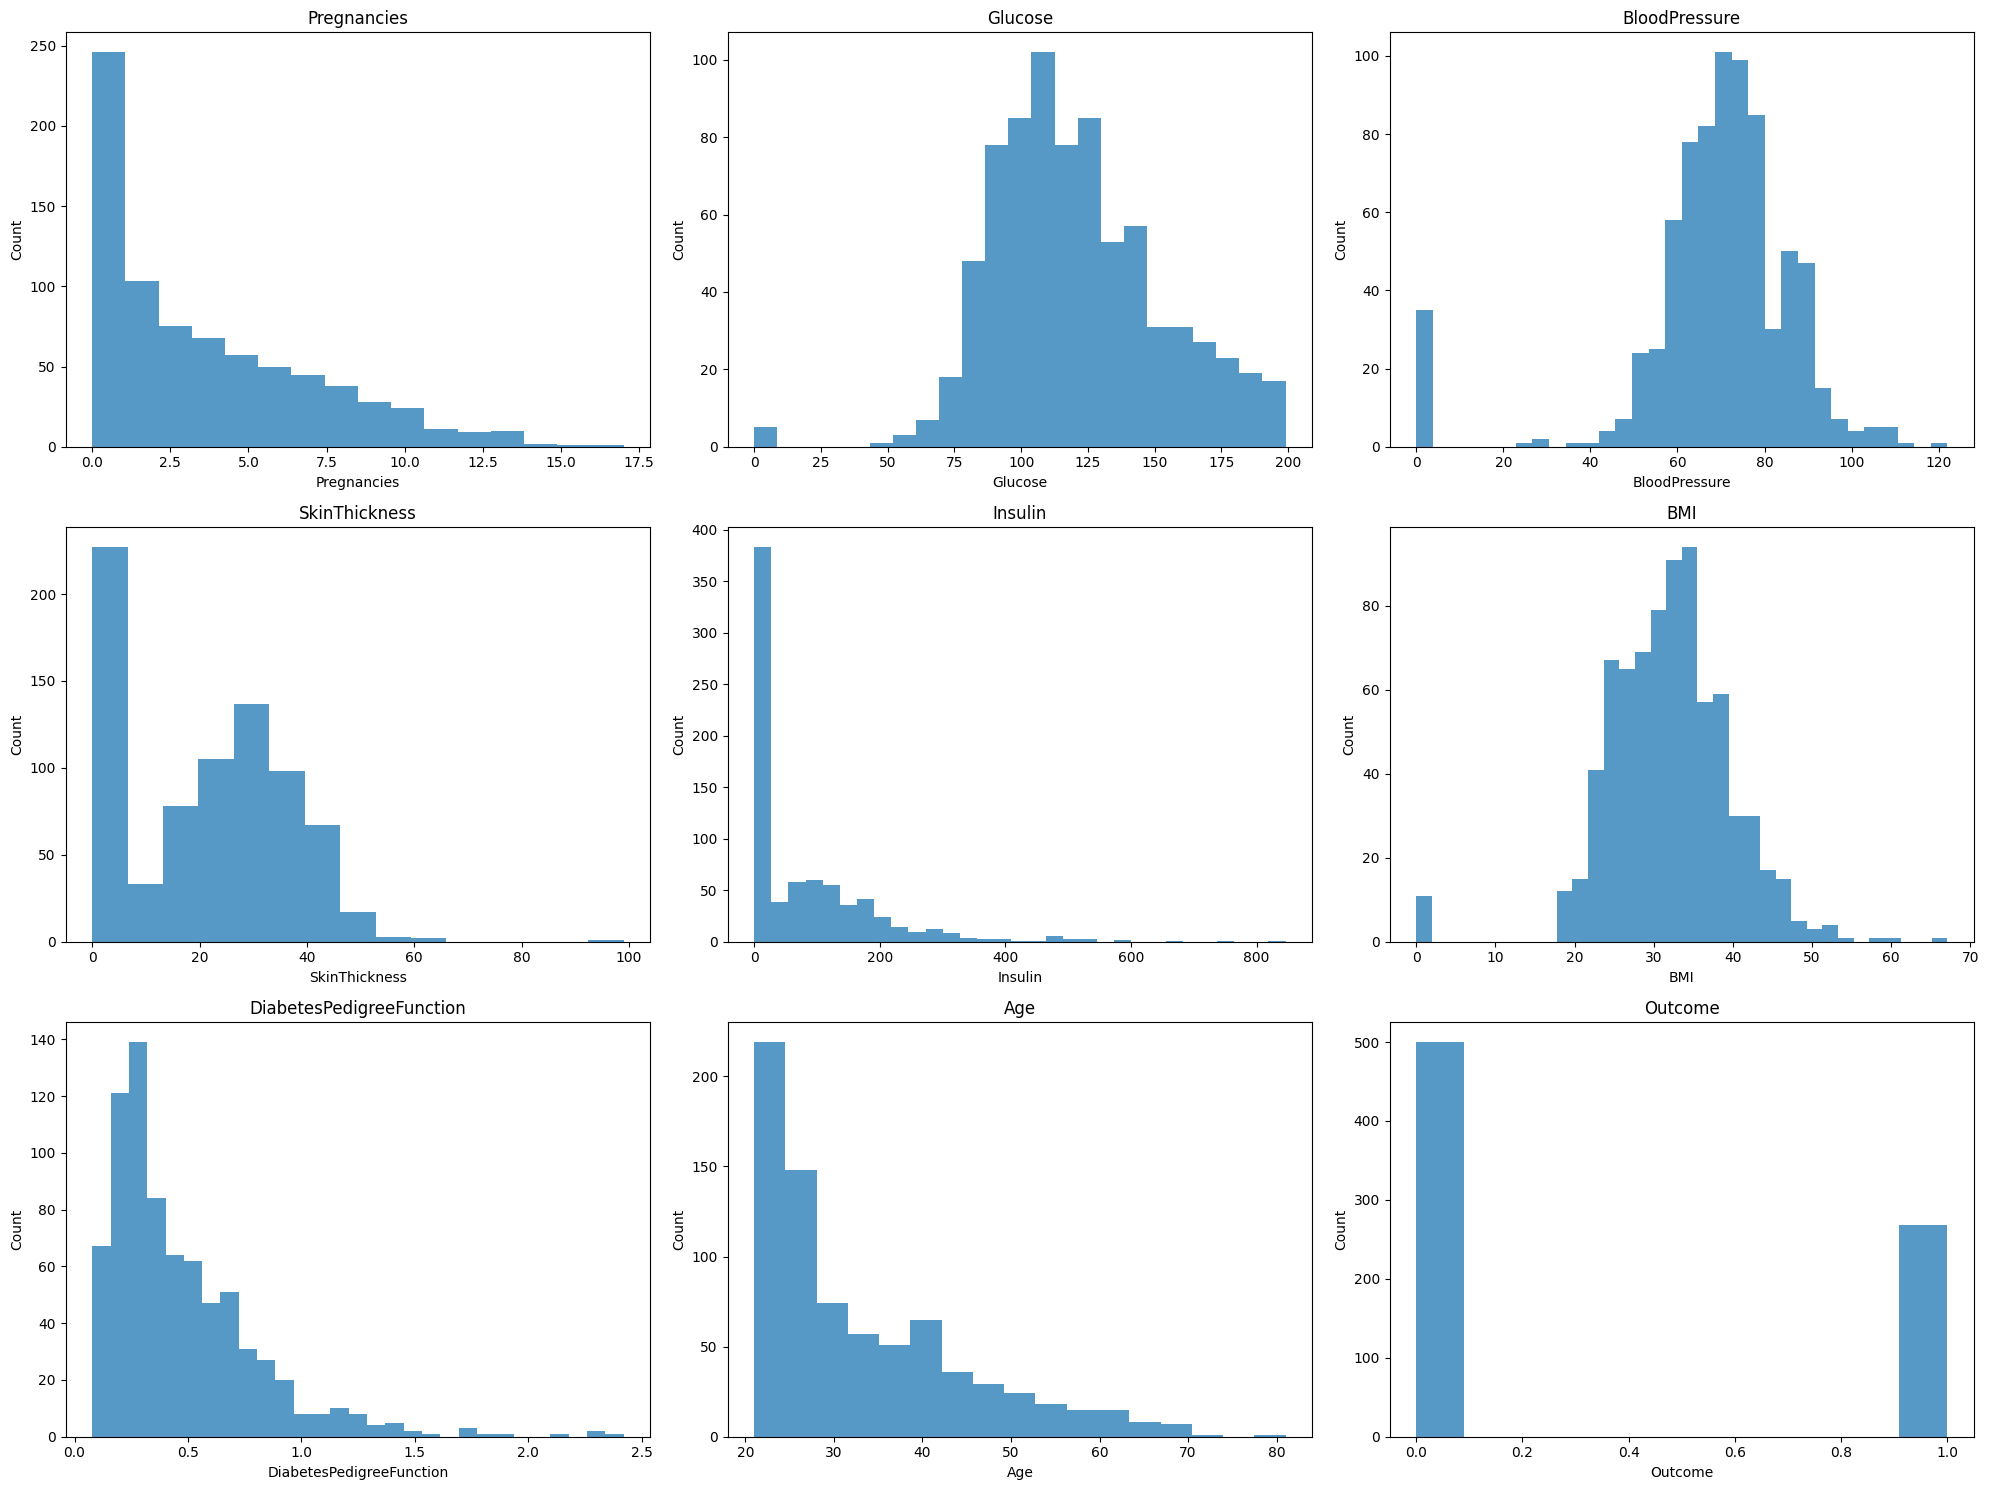

In [6]:
# Create histograms for each feature
plt.figure(figsize=(20, 15))
for i, column in enumerate(data_pd.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_pd[column], kde=False, linewidth=0)
    plt.title(column)

plt.tight_layout()
plt.show()

In [7]:
# Count of zero values in features where zero is not expected
zero_values = (
    data_pd[
        [
            "Pregnancies",
            "Glucose",
            "BloodPressure",
            "SkinThickness",
            "Insulin",
            "BMI",
            "DiabetesPedigreeFunction",
            "Age",
        ]
    ]
    == 0
).sum()
print("Count of zero values in features")
print(zero_values)

Count of zero values in features
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


# Remove samples that we don't expect 0 values in that particular feature.

In [8]:
# Remove samples where the following features have a value of 0
feature_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# keep the non-zero values
diabetes_data_clean = data_pd[(data_pd[feature_check] != 0).all(axis=1)]

# Save the cleaned data to a new CSV file
clean_data_path = "diabetes_clean_data.csv"
diabetes_data_clean.to_csv(clean_data_path, index=False)

In [9]:
# Count of zero values in features where zero is not expected
# reload my data_pd from the cleaned data
clean_file_path = "diabetes_clean_data.csv"
data_pd = pd.read_csv(clean_data_path)

zero_values = (
    data_pd[
        [
            "Pregnancies",
            "Glucose",
            "BloodPressure",
            "SkinThickness",
            "Insulin",
            "BMI",
            "DiabetesPedigreeFunction",
            "Age",
        ]
    ]
    == 0
).sum()
print("Count of zero values in features where zero is not expected")
print(zero_values)
data_pd.info()

Count of zero values in features where zero is not expected
Pregnancies                 56
Glucose                      0
BloodPressure                0
SkinThickness                0
Insulin                      0
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    int64  
 2   BloodPressure             392 non-null    int64  
 3   SkinThickness             392 non-null    int64  
 4   Insulin                   392 non-null    int64  
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome             

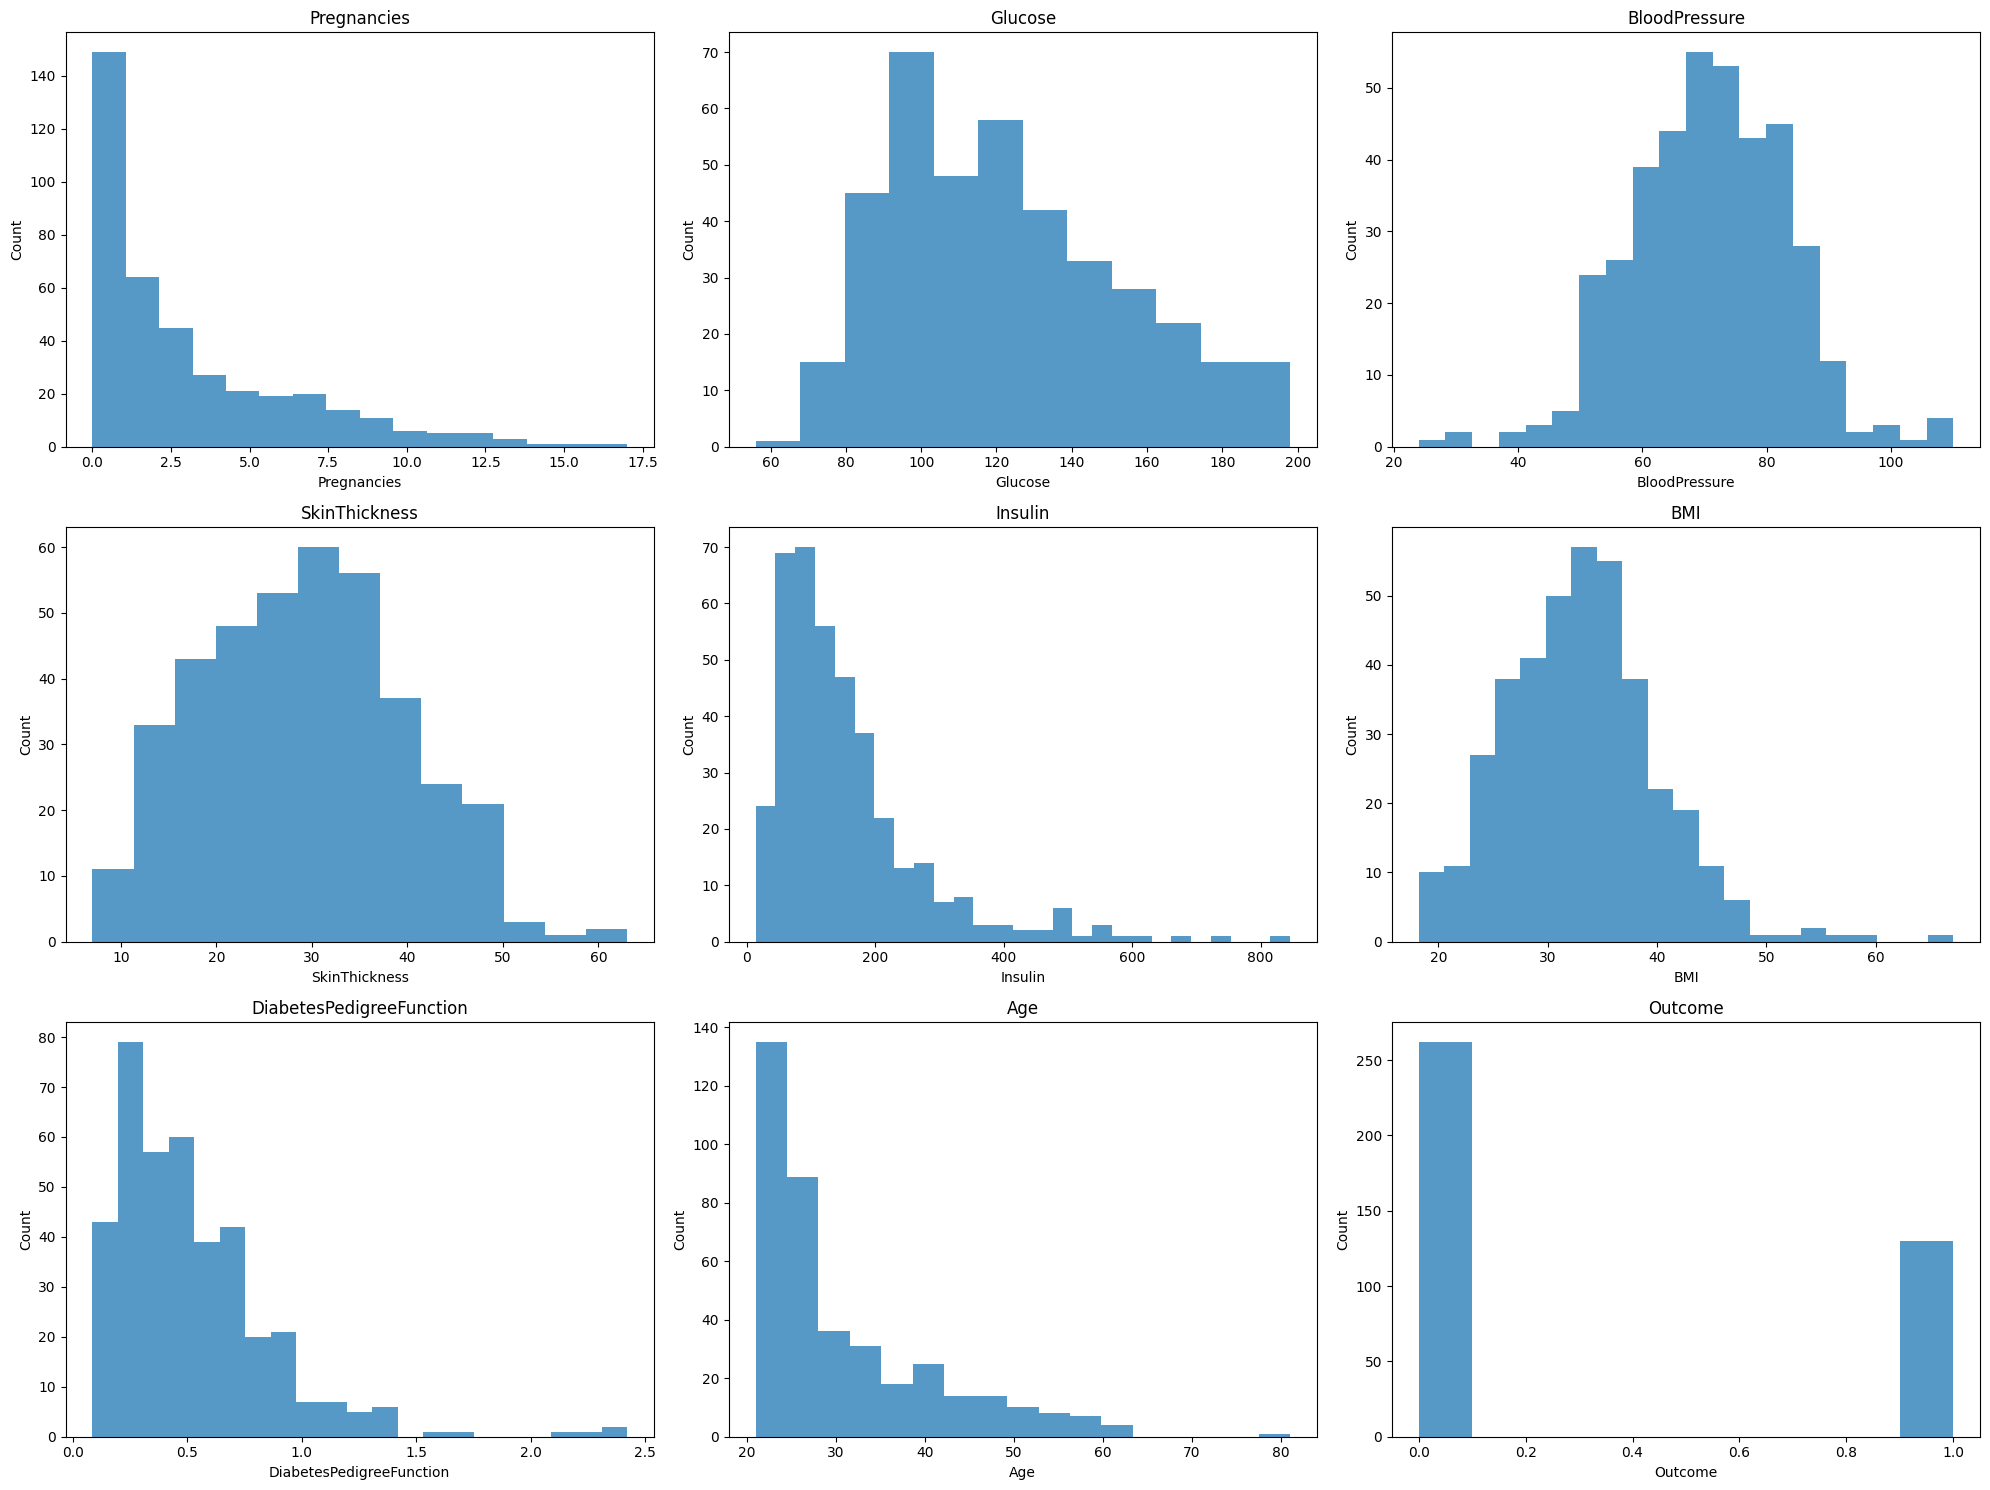

In [10]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(data_pd.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_pd[column], kde=False, linewidth=0)
    plt.title(column)

plt.tight_layout()
plt.show()

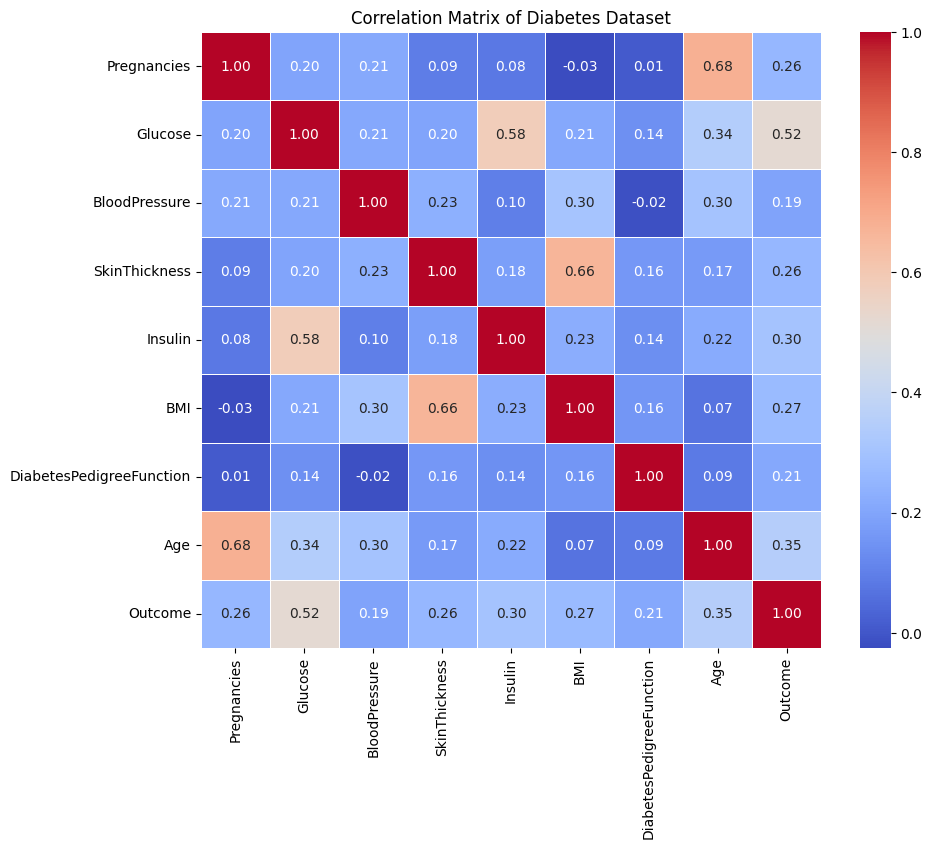

In [11]:
# get the correation from Pandas
correlation_matrix = data_pd.corr()

# Plot the heatmap to visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Diabetes Dataset")
plt.show()

# Check high correlation features.

In [12]:
# I want to find if the features are highly correlated
# if it is, I want to remove it to simplify my model
# threshold is set to 0.7
high_corr_threshold = 0.7
highly_corr_features = []

# Iterate over the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            highly_corr_features.append((correlation_matrix.columns[j], colname))

highly_corr_features

[]

### Obtain needed data from our raw csv file
1. Storing all features into different variables.
1. Standardizing all the data

In [13]:
# data_pd.head()

# seperate the data into different variables
# start with features = f1,f2...fn.
f1_preg = np.genfromtxt(clean_file_path, delimiter=",", skip_header=1, usecols=[0])
f2_glucose = np.genfromtxt(clean_file_path, delimiter=",", skip_header=1, usecols=[1])
f3_b_pressure = np.genfromtxt(
    clean_file_path, delimiter=",", skip_header=1, usecols=[2]
)
f4_skin_thick = np.genfromtxt(
    clean_file_path, delimiter=",", skip_header=1, usecols=[3]
)
f5_insulin = np.genfromtxt(clean_file_path, delimiter=",", skip_header=1, usecols=[4])
f6_bmi = np.genfromtxt(clean_file_path, delimiter=",", skip_header=1, usecols=[5])
f7_pedi_funct = np.genfromtxt(
    clean_file_path, delimiter=",", skip_header=1, usecols=[6]
)
f8_age = np.genfromtxt(clean_file_path, delimiter=",", skip_header=1, usecols=[7])
# labes = l1
l1_label = np.genfromtxt(clean_file_path, delimiter=",", skip_header=1, usecols=[8])

# shape of data input = 768 x 8
diabetes_input = np.c_[
    f1_preg,
    f2_glucose,
    f3_b_pressure,
    f4_skin_thick,
    f5_insulin,
    f6_bmi,
    f7_pedi_funct,
    f8_age,
]

# to fit the data input shape, we cahnge the label shape to 768 x 1
l1_label = l1_label.reshape(-1, 1)

standardised_data_input, data_row_of_means, data_row_of_stds = standardise(
    diabetes_input
)

### Using Logistic Regression method to build our prediction model with Numpy
1. Firstly building up a linear regression data matrix based on the standardised diabetes features matrix
1. Obtain optimal weights by using gradient descent algorithm:
    1. Initial weights can be whatever number, but to make life easy, we use zero in this case.
    1. Number of iteration 2,000,000 runs
    1. learning rate parameter => $\tau = 3.9\cdot s \cdot\left\|\mathbf{\Phi\left(X\right)}\right\|^{-2}$, where $s$ is sample size, $\mathbf{\Phi\left(X\right)}$ is our linear regression data matrix.

In [14]:
# firstly create an linear matrix from our input data
# note that the data is standardised at this point
# we create a matrix contains 1 in first column for creating a linear model
diabetes_data_matrix = linear_regression_data_input(diabetes_input)

# it's about time to use our kfold split to split our data into folds

# cost function and it's gradient function
cost_function = lambda weights: binary_logistic_regression_cost_function(
    diabetes_data_matrix, l1_label, weights
)
gradient_function = lambda weights: binary_logistic_regression_gradient(
    diabetes_data_matrix, l1_label, weights
)
# initial weights for gradient descent, we can choose what ever we want
# but in general, we just use 0 in this case.
initial_weights = np.zeros((diabetes_data_matrix.shape[1], 1))
# set the step size tau for each iteration
# use same parameter in tutorial
step_size = (
    3.9 * len(diabetes_data_matrix) / (np.linalg.norm(diabetes_data_matrix)) ** 2
)
# setup our target iteration and print_frequency
iterrations = 2000000
print_frequency = 100000
# apply gradient descent algorithm
optimal_weights, objective_values_ = gradient_descent(
    cost_function,
    gradient_function,
    initial_weights,
    step_size,
    iterrations,
    print_frequency,
)
# get the predicte labels, if the probability is greater than 0.5, we classify as diabetic
predicted_labels = binary_prediction_function(diabetes_data_matrix, optimal_weights)
# measure the accuracy comparing predicted VS real labels in our original data
diabetic_accuracy_rate_A = classification_accuracy(predicted_labels, l1_label)

Iteration 100000/2000000, current cost = 0.5607120051174392.
Iteration 200000/2000000, current cost = 0.5557426059344646.
Iteration 300000/2000000, current cost = 0.5510520130574339.
Iteration 400000/2000000, current cost = 0.5466123341940039.
Iteration 500000/2000000, current cost = 0.5424005520180705.
Iteration 600000/2000000, current cost = 0.5383974633062883.
Iteration 700000/2000000, current cost = 0.5345868597199063.
Iteration 800000/2000000, current cost = 0.530954889215075.
Iteration 900000/2000000, current cost = 0.5274895611344691.
Iteration 1000000/2000000, current cost = 0.5241803642141359.
Iteration 1100000/2000000, current cost = 0.5210179724974368.
Iteration 1200000/2000000, current cost = 0.5179940191853508.
Iteration 1300000/2000000, current cost = 0.5151009226873329.
Iteration 1400000/2000000, current cost = 0.5123317526011728.
Iteration 1500000/2000000, current cost = 0.5096801261291439.
Iteration 1600000/2000000, current cost = 0.5071401276345162.
Iteration 1700000/

### Result_A Report - Without K-Fold cross validation

In [15]:
# reserve all the weight into a dictionary
features_list = [
    "Intercept of the model",
    "Pregnancies",
    "Glucose",
    "Blood Pressure",
    "Skin Thickness",
    "Insulin",
    "BMI",
    "Diabetes Pedigree Function",
    "Age",
]
feature_weight_result_A = {}
for _ in range(len(features_list)):
    feature_weight_result_A[features_list[_]] = optimal_weights[_][0]

# print the final result
print("-------------------Final Report-------------------")
print(f"The optimal weight for all features is as following\n")
for _ in features_list:
    print(f"{_}: {feature_weight_result_A[_]}")

print(
    f"\nThe classification accuracy is roughly {round(100*diabetic_accuracy_rate_A,4)} %."
)

-------------------Final Report-------------------
The optimal weight for all features is as following

Intercept of the model: -2.8275388716451477
Pregnancies: 0.10752845736720179
Glucose: 0.022312180840106933
Blood Pressure: -0.03210746511667569
Skin Thickness: 0.021939365408216036
Insulin: 0.001060149499457693
BMI: -0.003541191711069177
Diabetes Pedigree Function: 0.5110482770447733
Age: 0.010240917732935334

The classification accuracy is roughly 76.7857 %.


#### Implement K-fold cross validation to select a proper parameter alpha for ridge logistic regression.

We consider implement ridge regression into our model, we can add Redge Regression Penalty as following:
$$
L(w) = \frac{1}{s} \left( \sum_{i=1}^{s} \log \left[ 1 + \exp(f(x^{(i)}, w)) \right] - y_i \cdot f(x^{(i)}, w) \right) + \frac{\alpha}{2} ||w||^2,
$$

$$
\nabla L(w) = \frac{1}{s}(X^T \left( \sigma(Xw) - y \right)) + \alpha w,
$$

In [16]:
K = 10
# Define a range of alpha values for KFold_cross_validation
alphas = np.logspace(-4, 4, 9)

# Error evaluation function for your logistic regression model
error_evaluation = lambda features, labels, weights: logistic_error_evaluation(
    features, labels, weights
)


def train_logistic_regression_with_ridge(data_matrix, data_outputs, alpha):
    optimal_weights, cost = gradient_descent(
        cost_function=lambda weights: binary_ridge_logistic_regression_cost_function(
            data_matrix, data_outputs, weights, alpha  # Include alpha here
        ),
        gradient=lambda weights: binary_ridge_logistic_regression_gradient(
            data_matrix, data_outputs, weights, alpha  # Include alpha here
        ),
        initial_weights=np.zeros((data_matrix.shape[1], 1)),
        step_size=(3.9 * len(data_matrix) / (np.linalg.norm(data_matrix)) ** 2),
        no_of_iterations=1000,
        print_output=10000,
    )
    return optimal_weights  # Return the optimal weights


validation_error = lambda alpha: KFold_cross_validation(
    diabetes_data_matrix,
    l1_label,
    K,
    lambda data_matrix, data_outputs: train_logistic_regression_with_ridge(
        data_matrix, data_outputs, alpha
    ),
    error_evaluation,
)[
    1
]  # return the error

B_optimal_alpha = grid_search(validation_error, alphas)

# use the optimal alpha to train the model again to obtain the optimal weights
optimal_weights = KFold_cross_validation(
    diabetes_data_matrix,
    l1_label,
    K,
    lambda data_matrix, data_outputs: train_logistic_regression_with_ridge(
        data_matrix, data_outputs, B_optimal_alpha
    ),
    error_evaluation,
)[0]

print(f"Optimal alpha: {B_optimal_alpha}\nOptimal weights: {optimal_weights}")

Iteration completed after 1000/1000, Cost = 0.5881086238473332.
Iteration completed after 1000/1000, Cost = 0.5855449887527903.
Iteration completed after 1000/1000, Cost = 0.5782369566847213.
Iteration completed after 1000/1000, Cost = 0.5786313988385652.
Iteration completed after 1000/1000, Cost = 0.5905617002553063.
Iteration completed after 1000/1000, Cost = 0.561508701487072.
Iteration completed after 1000/1000, Cost = 0.5730717780728045.
Iteration completed after 1000/1000, Cost = 0.5703839881629517.
Iteration completed after 1000/1000, Cost = 0.572341205963395.
Iteration completed after 1000/1000, Cost = 0.5675708234061593.
Iteration completed after 1000/1000, Cost = 0.584404591667474.
Iteration completed after 1000/1000, Cost = 0.5790697494820587.
Iteration completed after 1000/1000, Cost = 0.5827678670498154.
Iteration completed after 1000/1000, Cost = 0.5679496371478414.
Iteration completed after 1000/1000, Cost = 0.5773149930393088.
Iteration completed after 1000/1000, Cost =

Since we got the alpha, we can narrow down and do it again with alhpa closer to it's scale

In [17]:
# let's do i agian with new alpha
K = 10
# power = np.log10(B_optimal_alpha)
# alphas = np.arange(B_optimal_alpha - 10**power, B_optimal_alpha + 10**power, 10)
step = B_optimal_alpha
alphas = np.arange(-5 * step, 6 * step, step)

validation_error = lambda alpha: KFold_cross_validation(
    diabetes_data_matrix,
    l1_label,
    K,
    lambda data_matrix, data_outputs: train_logistic_regression_with_ridge(
        data_matrix, data_outputs, alpha
    ),
    error_evaluation,
)[
    1
]  # return the error

B_optimal_alpha = grid_search(validation_error, alphas)

# use the optimal alpha to train the model again to obtain the optimal weights
result_b_optimal_weights = KFold_cross_validation(
    diabetes_data_matrix,
    l1_label,
    K,
    lambda data_matrix, data_outputs: train_logistic_regression_with_ridge(
        data_matrix, data_outputs, B_optimal_alpha
    ),
    error_evaluation,
)[0]

print(
    f"Optimal alpha: {B_optimal_alpha}\nOptimal weights: \n{result_b_optimal_weights}"
)
# get the predicte labels, if the probability is greater than 0.5, we classify as diabetic
predicted_labels = binary_prediction_function(
    diabetes_data_matrix, result_b_optimal_weights
)
# measure the accuracy comparing predicted VS real labels in our original data
diabetic_accuracy_rate_B = classification_accuracy(predicted_labels, l1_label)

Iteration completed after 1000/1000, Cost = -1.4399452082986057.
Iteration completed after 1000/1000, Cost = -1.200275627522286.
Iteration completed after 1000/1000, Cost = -1.0828245052824879.
Iteration completed after 1000/1000, Cost = -1.08402423193238.
Iteration completed after 1000/1000, Cost = -1.334181831572069.
Iteration completed after 1000/1000, Cost = -1.3670987389017195.
Iteration completed after 1000/1000, Cost = -1.9295284412614597.
Iteration completed after 1000/1000, Cost = -1.5377869962013495.
Iteration completed after 1000/1000, Cost = -1.3887820959239692.
Iteration completed after 1000/1000, Cost = -1.4240676427181649.
Iteration completed after 1000/1000, Cost = -0.03952324845758548.
Iteration completed after 1000/1000, Cost = 0.05488343167358767.
Iteration completed after 1000/1000, Cost = 0.0886876227428458.
Iteration completed after 1000/1000, Cost = 0.061458473459107155.
Iteration completed after 1000/1000, Cost = -0.1573840439039974.
Iteration completed after 10

### Result Report - With K-fold cross validation and logistic ridge regression

In [18]:
# reserve all the weight into a dictionary
features_list = [
    "Intercept of the model",
    "Pregnancies",
    "Glucose",
    "Blood Pressure",
    "Skin Thickness",
    "Insulin",
    "BMI",
    "Diabetes Pedigree Function",
    "Age",
]
feature_weight_result_B = {}
for _ in range(len(features_list)):
    feature_weight_result_B[features_list[_]] = optimal_weights[_][0]

# print the final result
print("-------------------Final Report-------------------")
print(f"Alpha = {B_optimal_alpha}")
print(f"The optimal weight for all features are as following\n")
for _ in features_list:
    print(f"{_}: {feature_weight_result_B[_]}")

print(
    f"\nThe classification accuracy is roughly {round(100*diabetic_accuracy_rate_B,4)} %."
)

# print(optimal_weights)

-------------------Final Report-------------------
Alpha = -20.0
The optimal weight for all features are as following

Intercept of the model: -0.0017103415262736887
Pregnancies: 0.00994707513511086
Glucose: 0.01246212722738007
Blood Pressure: -0.03650336131206125
Skin Thickness: 0.006387798987862179
Insulin: 0.0021339661375140003
BMI: -0.013580247405252863
Diabetes Pedigree Function: 0.00038678060551452554
Age: 0.011381163107347386

The classification accuracy is roughly 71.9388 %.


Interestingly, the ultimate alpha for penalty is really low so we try to use k-fold cross validation without ridge penalty to obtain average weight among all folds.

In [19]:
K = 10  # Number of folds


def train_simple_logistic_regression(data_matrix, data_outputs):
    # Use gradient descent or any other optimization method
    optimal_weights, cost = gradient_descent(
        # this time, we use the original binary logistic regression cost function instead of ridge
        cost_function=lambda weights: binary_logistic_regression_cost_function(
            data_matrix, data_outputs, weights
        ),
        gradient=lambda weights: binary_logistic_regression_gradient(
            data_matrix, data_outputs, weights
        ),
        initial_weights=np.zeros((data_matrix.shape[1], 1)),
        step_size=(3.9 * len(data_matrix) / (np.linalg.norm(data_matrix)) ** 2),
        no_of_iterations=100000,
        print_output=1000000,
    )
    return optimal_weights


error_evaluation = lambda features, labels, weights: logistic_error_evaluation(
    features, labels, weights
)

# Perform k-fold cross-validation
optimal_weights, validation_error = KFold_cross_validation(
    diabetes_data_matrix,
    l1_label,
    K,
    lambda data_matrix, data_outputs: train_simple_logistic_regression(
        data_matrix, data_outputs
    ),
    error_evaluation,
)

print(f"Validation error: {validation_error}\nOptimal weights: \n{optimal_weights}")
# get the predicte labels, if the probability is greater than 0.5, we classify as diabetic
predicted_labels = binary_prediction_function(diabetes_data_matrix, optimal_weights)
# measure the accuracy comparing predicted VS real labels in our original data
diabetic_accuracy_rate_C = classification_accuracy(predicted_labels, l1_label)

Iteration completed after 100000/100000, Cost = 0.5723847036968646.
Iteration completed after 100000/100000, Cost = 0.562356512547068.
Iteration completed after 100000/100000, Cost = 0.5659365904632581.
Iteration completed after 100000/100000, Cost = 0.5342561984682354.
Iteration completed after 100000/100000, Cost = 0.5527196377473657.
Iteration completed after 100000/100000, Cost = 0.5677049067914467.
Iteration completed after 100000/100000, Cost = 0.5588084562090103.
Iteration completed after 100000/100000, Cost = 0.5619395272117569.
Iteration completed after 100000/100000, Cost = 0.5554952536777339.
Iteration completed after 100000/100000, Cost = 0.5598676054371108.
Validation error: 0.30403846153846154
Optimal weights: 
[[-0.17234461]
 [ 0.12378552]
 [ 0.01812493]
 [-0.04769037]
 [ 0.0286277 ]
 [ 0.00182983]
 [-0.03106456]
 [ 0.05729634]
 [ 0.00326335]]


### Result Report - With K-fold cross validation but without ridge penalty

In [20]:
# reserve all the weight into a dictionary
features_list = [
    "Intercept of the model",
    "Pregnancies",
    "Glucose",
    "Blood Pressure",
    "Skin Thickness",
    "Insulin",
    "BMI",
    "Diabetes Pedigree Function",
    "Age",
]
feature_weight_result_C = {}
for _ in range(len(features_list)):
    feature_weight_result_C[features_list[_]] = optimal_weights[_][0]

# print the final result
print("-------------------Final Report-------------------")
print(f"The optimal weight for all features are as following\n")
for _ in features_list:
    print(f"{_}: {feature_weight_result_C[_]}")

print(
    f"\nThe classification accuracy is roughly {round(100*diabetic_accuracy_rate_C,4)} %."
)

# print(optimal_weights)

-------------------Final Report-------------------
The optimal weight for all features are as following

Intercept of the model: -0.17234460782881433
Pregnancies: 0.12378552061331984
Glucose: 0.018124932929627115
Blood Pressure: -0.047690374511070215
Skin Thickness: 0.028627703581008874
Insulin: 0.001829833139196258
BMI: -0.031064561756238847
Diabetes Pedigree Function: 0.05729633704991148
Age: 0.0032633485093755857

The classification accuracy is roughly 71.4286 %.


Using Chi-Squared to test if one models is better than the other

In [21]:
import scipy.stats as stats

total_samples = 392
# Acuuracy use above result
accuracy_A = 70.41 / 100
accuracy_B = 71.43 / 100

# obrain the correct/incorrect classification using the accuracy report above
correct_A = round(total_samples * accuracy_A)
correct_B = round(total_samples * accuracy_B)
incorrect_A = total_samples - correct_A
incorrect_B = total_samples - correct_B

contingency_table = [[correct_A, incorrect_A], [correct_B, incorrect_B]]

# conduct the test
chi2, p_value, dof, expected = stats.chi2_contingency(
    contingency_table, correction=False
)

p_value

0.7530904146412407

### Approach 2, KNN using Numpy

In [22]:
def KFold_split(data_size, K):
    np.random.seed(123456789)
    indexes = np.random.permutation(data_size)
    m, r = divmod(data_size, K)
    indexes_split = [
        indexes[i * m + min(i, r) : (i + 1) * m + min(i + 1, r)] for i in range(K)
    ]
    return indexes_split


def KFold_cross_validation_knn(
    data_inputs, data_outputs, K, labels_evaluation, missclassification_evaluation, knn
):
    data_size = len(data_inputs)
    indexes_split = KFold_split(data_size, K)

    average_accuracy = 0
    for i in range(K):
        training_indexes = np.concatenate(
            [indexes_split[j] for j in range(K) if (j != i)]
        )

        predicted_labels = labels_evaluation(
            data_inputs[indexes_split[i]],
            data_inputs[training_indexes],
            data_outputs[training_indexes],
            knn,
        )

        accuracy = missclassification_evaluation(
            predicted_labels, data_outputs[indexes_split[i]]
        )
        average_accuracy += accuracy / K

    error = 1.0 - average_accuracy
    return error, average_accuracy


def grid_search(objective, grid):
    values = np.array([])
    for point in grid:
        values = np.append(values, objective(point))
    return grid[np.argmin(values)]


data_size = len(diabetes_data_matrix)


def target(Knn, data_size, x, y, K):
    indexes_split = KFold_split(data_size, K)

    average_accuracy = 0
    for i in range(K):
        training_indexes = np.concatenate(
            [indexes_split[j] for j in range(K) if (j != i)]
        )

        predicted_labels = binary_nearest_neighbor_classification(
            x[indexes_split[i]],  # validation set
            x[training_indexes],  # training set
            y[training_indexes],  # training labels
            Knn,
        )

        accuracy = classification_accuracy(predicted_labels, y[indexes_split[i]])
        average_accuracy += accuracy / K

    error = 1.0 - average_accuracy
    return error


def run_knn_with_cross_validation(data_size, x, y, K):
    # initialize the neighbors
    k_values = np.arange(1, 101)
    best_k = grid_search(
        lambda knn: target(knn, data_size, x, y, K=10),
        k_values,
    )
    cross_validation_errors = []
    accuracies = []

    for _ in range(10):
        error, accuracy = KFold_cross_validation_knn(
            x,
            y,
            K,
            binary_nearest_neighbor_classification,
            classification_accuracy,
            best_k,
        )
        cross_validation_errors.append(error)
        accuracies.append(accuracy)

    average_error = np.mean(cross_validation_errors)
    average_accuracy = np.mean(accuracies)

    return best_k, average_error, average_accuracy


data_size = len(diabetes_input)
best_k, average_error, average_accuracy = run_knn_with_cross_validation(
    data_size, diabetes_input, l1_label, K=10
)

print("-------------------Final Report-------------------")
print("Best number of neighbors:", best_k)
print(f"Accuracy: {average_accuracy}")

-------------------Final Report-------------------
Best number of neighbors: 2
Accuracy: 0.625587606837607


In [23]:
# Try to remove some features and see if we can improve the accuracy
# start removing the top 2~3 features that has the highest correlation by commenting out the features

diabetes_input2 = np.c_[
    # f1_preg,
    f2_glucose,
    f3_b_pressure,
    # f4_skin_thick,
    f5_insulin,
    f6_bmi,
    f7_pedi_funct,
    f8_age,
]

data_size = len(diabetes_input2)
best_k, average_error, average_accuracy = run_knn_with_cross_validation(
    data_size, diabetes_input2, l1_label, K=10
)

print("-------------------Final Report-------------------")
print("Best number of neighbors:", best_k)
print(f"Accuracy: {average_accuracy}")

-------------------Final Report-------------------
Best number of neighbors: 2
Accuracy: 0.622950443786982


In [24]:
total_samples = 392
# Acuuracy use above result
accuracy_A = 70.41 / 100
accuracy_B = 62.56 / 100

# obrain the correct/incorrect classification using the accuracy report above
correct_A = round(total_samples * accuracy_A)
correct_B = round(total_samples * accuracy_B)
incorrect_A = total_samples - correct_A
incorrect_B = total_samples - correct_B

contingency_table = [[correct_A, incorrect_A], [correct_B, incorrect_B]]

# conduct the test
chi2, p_value, dof, expected = stats.chi2_contingency(
    contingency_table, correction=False
)

p_value

0.019032551971190945

#### Extra Code using SKlearn - SVM

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

X = diabetes_input
y = l1_label.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("-------------------Final Report SVM-------------------")
print(f"Accuracy: {accuracy}")

-------------------Final Report SVM-------------------
Accuracy: 0.7341772151898734


In [26]:
# use removed features dataset2
X = diabetes_input2
y = l1_label.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("-------------------Final Report SVM-------------------")
print(f"Accuracy: {accuracy}")

-------------------Final Report SVM-------------------
Accuracy: 0.759493670886076


In [27]:
total_samples = 392
# Acuuracy use above result
accuracy_A = 70.41 / 100
accuracy_B = 73.42 / 100

# obrain the correct/incorrect classification using the accuracy report above
correct_A = round(total_samples * accuracy_A)
correct_B = round(total_samples * accuracy_B)
incorrect_A = total_samples - correct_A
incorrect_B = total_samples - correct_B

contingency_table = [[correct_A, incorrect_A], [correct_B, incorrect_B]]

# conduct the test
chi2, p_value, dof, expected = stats.chi2_contingency(
    contingency_table, correction=False
)

p_value

0.34015034594793286

In [28]:
total_samples = 392
# Acuuracy use above result
accuracy_A = 62.56 / 100
accuracy_B = 73.42 / 100

# obrain the correct/incorrect classification using the accuracy report above
correct_A = round(total_samples * accuracy_A)
correct_B = round(total_samples * accuracy_B)
incorrect_A = total_samples - correct_A
incorrect_B = total_samples - correct_B

contingency_table = [[correct_A, incorrect_A], [correct_B, incorrect_B]]

# conduct the test
chi2, p_value, dof, expected = stats.chi2_contingency(
    contingency_table, correction=False
)

p_value

0.000995682849707957